# 🚀 PaperSafeStrategy — Complete Quickstart Notebook

This notebook shows:
1. What this model is
2. How to run it
3. How to read plots/results
4. What to do before live trading


## 0) What you should do (simple checklist)

- ✅ Run this notebook top-to-bottom
- ✅ Check equity curve + drawdown
- ✅ Confirm backtest remains positive
- ✅ Run paper trading for 2–4 weeks
- ✅ Go live only if paper metrics stay good


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, yfinance as yf
from pathlib import Path
sns.set_theme(style='whitegrid')
REPO = Path('.').resolve()
print('Repo:', REPO)

Repo: /root/.openclaw/workspace/last-model-repo


## 1) Load market data (BTC hourly)

In [2]:
df = yf.download('BTC-USD', period='2y', interval='1h', auto_adjust=True, progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]
df = df.rename(columns=str.lower).dropna()
print(df.shape)
df.head()

(17389, 5)


,close,high,low,open,volume
Datetime,,,,,
2024-02-13 10:00:00+00:00,49890.804688,50217.500000,49888.492188,50217.500000,0
2024-02-13 11:00:00+00:00,49984.683594,50025.226562,49692.789062,49879.433594,261152768
2024-02-13 12:00:00+00:00,49876.753906,49995.363281,49824.171875,49995.363281,0
2024-02-13 13:00:00+00:00,49600.355469,49939.539062,49254.441406,49876.703125,1677209600
2024-02-13 14:00:00+00:00,48741.460938,49636.917969,48599.031250,49545.531250,2792251392


## 2) Build core indicators (aligned with strategy logic)

In [3]:
close=df['close']
df['ema_fast']=close.ewm(span=15, adjust=False).mean()
df['ema_slow']=close.ewm(span=81, adjust=False).mean()

delta=close.diff()
gain=delta.clip(lower=0).rolling(14).mean()
loss=(-delta.clip(upper=0)).rolling(14).mean()
rs=gain/loss
df['rsi']=100-(100/(1+rs))

ret=close.pct_change()
df['vol']=ret.rolling(24).std()

df_4h = df['close'].resample('4h').last().dropna().to_frame('close')
df_4h['ema50_4h']=df_4h['close'].ewm(span=50, adjust=False).mean()
df_4h['ema200_4h']=df_4h['close'].ewm(span=200, adjust=False).mean()
trend4h=(df_4h['ema50_4h']>df_4h['ema200_4h']).reindex(df.index, method='ffill')
df['uptrend4h']=trend4h.astype(int)

df=df.dropna()
df[['close','ema_fast','ema_slow','rsi','vol','uptrend4h']].tail()

,close,ema_fast,ema_slow,rsi,vol,uptrend4h
Datetime,,,,,,
2026-02-13 06:00:00+00:00,66310.007812,66357.359239,67561.912477,57.195647,0.006538,0
2026-02-13 07:00:00+00:00,66145.000000,66330.814334,67527.353636,60.034954,0.006532,0
2026-02-13 08:00:00+00:00,66569.484375,66360.648089,67503.990971,63.116453,0.006686,0
2026-02-13 09:00:00+00:00,66887.132812,66426.458680,67488.945650,64.235395,0.006613,0
2026-02-13 10:00:00+00:00,66841.968750,66478.397439,67473.165726,71.203200,0.006494,0


## 3) Signal visualization

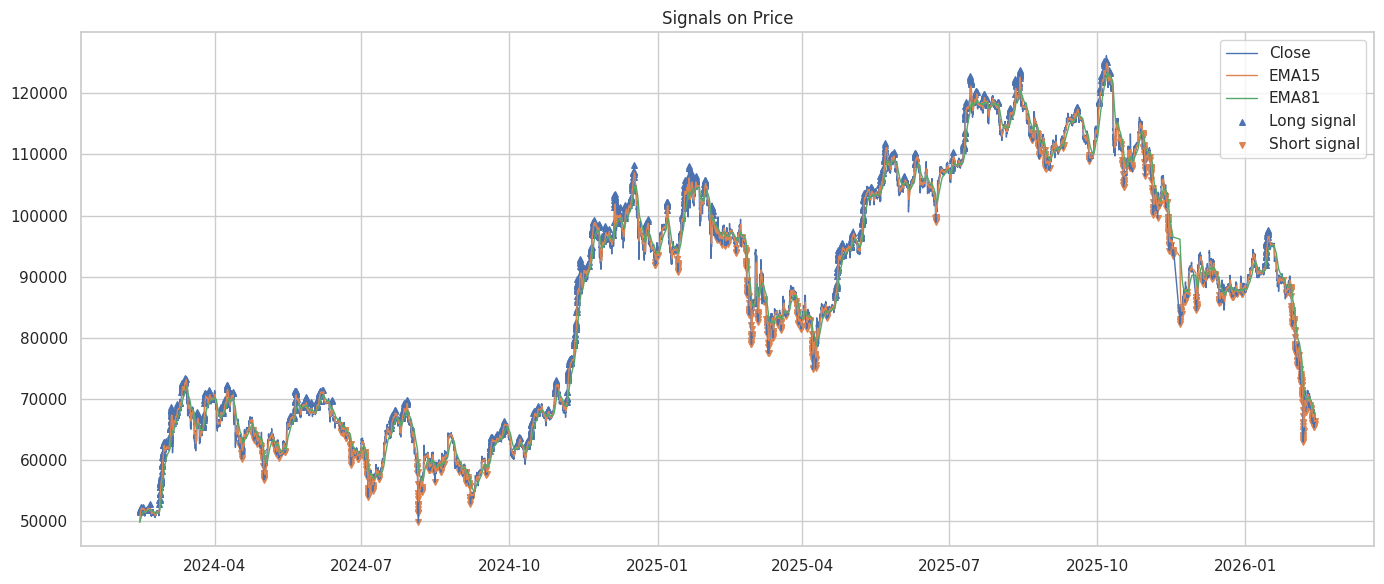

Long: 1233 Short: 1102


In [4]:
long_sig=(df['ema_fast']>df['ema_slow'])&(df['rsi']>65)&(df['vol']>0.003)&(df['uptrend4h']==1)
short_sig=(df['ema_fast']<df['ema_slow'])&(df['rsi']<35)&(df['vol']>0.003)&(df['uptrend4h']==0)

df['sig']=0
df.loc[long_sig,'sig']=1
df.loc[short_sig,'sig']=-1

plt.figure(figsize=(14,6))
plt.plot(df.index, df['close'], label='Close', lw=1)
plt.plot(df.index, df['ema_fast'], label='EMA15', lw=1)
plt.plot(df.index, df['ema_slow'], label='EMA81', lw=1)
bi=df.index[df['sig']==1]; si=df.index[df['sig']==-1]
plt.scatter(bi, df.loc[bi,'close'], marker='^', s=16, label='Long signal')
plt.scatter(si, df.loc[si,'close'], marker='v', s=16, label='Short signal')
plt.title('Signals on Price')
plt.legend(); plt.tight_layout(); plt.show()
print('Long:', (df['sig']==1).sum(), 'Short:', (df['sig']==-1).sum())

## 4) Proxy equity + drawdown plots (quick intuition)

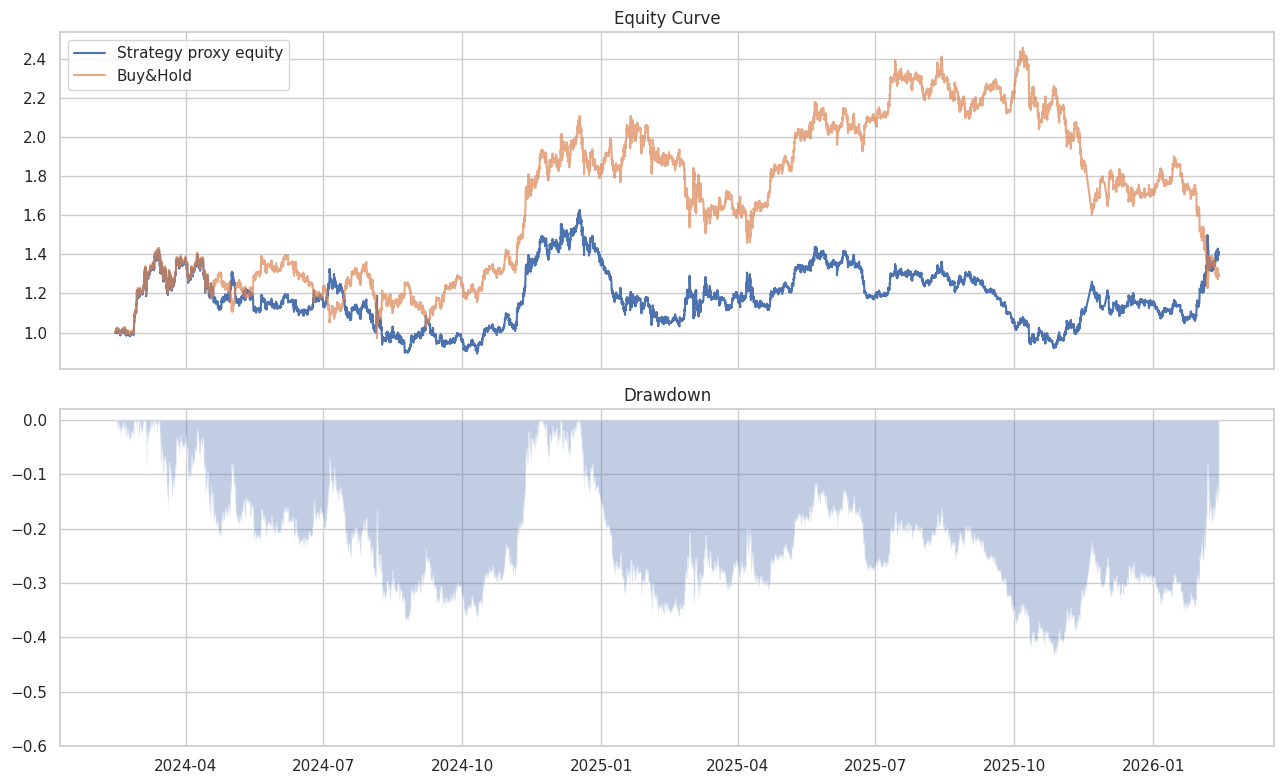

Proxy return %: 39.76
Proxy max DD %: -43.5


In [5]:
pos=df['sig'].replace(0,np.nan).ffill().fillna(0)
ret=df['close'].pct_change().fillna(0)
strat_ret=pos.shift(1).fillna(0)*ret

equity=(1+strat_ret).cumprod()
dd=equity/equity.cummax()-1

fig,ax=plt.subplots(2,1,figsize=(13,8),sharex=True)
ax[0].plot(equity.index,equity.values,label='Strategy proxy equity')
ax[0].plot((1+ret).cumprod().index,(1+ret).cumprod().values,label='Buy&Hold',alpha=.7)
ax[0].legend(); ax[0].set_title('Equity Curve')
ax[1].fill_between(dd.index, dd.values, 0, alpha=0.35)
ax[1].set_title('Drawdown')
ax[1].set_ylim(min(-0.6, dd.min()*1.1),0.02)
plt.tight_layout(); plt.show()
print('Proxy return %:', round((equity.iloc[-1]-1)*100,2))
print('Proxy max DD %:', round(dd.min()*100,2))

## 5) Run official Freqtrade backtest (authoritative)

In [6]:
import subprocess
cmd = 'freqtrade backtesting --enable-protections --userdir freqtrade --config freqtrade/config.paper.json --strategy PaperSafeStrategy --timerange 20250301-20260201 --timeframe 1h'
print('Command:', cmd)
# Uncomment to run:
# out = subprocess.run(cmd, shell=True, capture_output=True, text=True)
# print(out.stdout[-6000:])


Command: freqtrade backtesting --enable-protections --userdir freqtrade --config freqtrade/config.paper.json --strategy PaperSafeStrategy --timerange 20250301-20260201 --timeframe 1h


## 6) How to use this model (paper first)

### Start paper trading
```bash
cd /root/.openclaw/workspace/trading
source .venv/bin/activate
freqtrade trade --userdir freqtrade --config freqtrade/config.paper.json --strategy PaperSafeStrategy
```

### Stop
```bash
pkill -f "freqtrade trade --userdir freqtrade --config freqtrade/config.paper.json"
```

### Daily checks
- PnL positive over rolling week
- Max drawdown within your risk limit
- No abnormal trade bursts / API errors


## 7) Go-live criteria (strict)

Go live only if all true for at least 2–4 weeks paper run:
- Profit factor > 1.1
- Drawdown acceptable to you
- Stable behavior across volatile and calm days
- No operational issues
